# Sex Differences, Cortical Hierarchy, Receptive Field Size

### Purpose:
1. Use our filtered data to explore differences in receptive field sizes
2. Specifically we need to fix errors in our code that we are getting to match our filtered data to the receptive field data.
3. Create figures hihglighting experimental results

### Protocols:
1. Import all Allen Data for Neuropixels
2. Run code to get our filtered data sessions for male and female mice from LGN and AM brain regions
3. Troubleshoot errors in code
4. Align unit id of filtered data sessions to corresponding visual cortical regions AM or LGN 
5. Plot graph

### Expected Results:
1. plot receptive field outline of AM and LGN of a signle session in the same graph

### Installing AllenSDK in local environment

In [1]:
pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install allensdk

Defaulting to user installation because normal site-packages is not writeable
  Using cached ruamel.yaml-0.17.21-py3-none-any.whl (109 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deeplabcut 2.1.6.2 requires h5py~=2.7, but you have h5py 3.6.0 which is incompatible.
deeplabcut 2.1.6.2 requires matplotlib==3.0.3, but you have matplotlib 3.1.1 which is incompatible.
deeplabcut 2.1.6.2 requires numpy==1.16.4, but you have numpy 1.21.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


### Import Packages

In [3]:
import os
import shutil
import allensdk
import pprint
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats as st
from allensdk.brain_observatory.ecephys.stimulus_analysis.drifting_gratings import DriftingGratings
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# Graphing for indivdual units
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.stimulus_analysis.receptive_field_mapping import ReceptiveFieldMapping

#Graphing for RF Distribution and RF outlines
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.utils import resample 

import warnings
warnings.filterwarnings("ignore")

### Import Neuropixels Data cache object and create directory on LongLeaf storage

In [4]:
#data directory for extracellular ephysdata: /overflow/NSCI274/projects/ecephysdata/
data_directory = "/overflow/NSCI274/projects/ecephysdata/"

#import the data folder to your in Jupternotebook and copy the complete directory here
code_directory = "/nas/longleaf/home/renzhi/"

manifest_path = os.path.join(data_directory,"manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

#### All neuropixel sessions 

In [5]:
sessions = cache.get_session_table()

#total_sessions = len(sessions)
#sessions.head(n)

### Data Filter

#### Male with LGN

In [22]:
filtered_sessions_male_LGN = sessions[(sessions.sex == 'M') & \
                             (['LGd' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]

total_sessions_male_LGN = len(filtered_sessions_male_LGN)

print(str(total_sessions_male_LGN))

#show the graph
#filtered_sessions_male_LGN.head()

28


#### Male with AM

In [23]:
filtered_sessions_male_AM = sessions[(sessions.sex == 'M') & \
                             (['VISam' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
total_sessions_male_AM = len(filtered_sessions_male_AM)

print(str(total_sessions_male_AM))

#show the graph
#filtered_sessions_male_AM.head()

38


#### Female with LGN

In [24]:
filtered_sessions_female_LGN = sessions[(sessions.sex == 'F') & \
                             #(sessions.full_genotype.str.find('Sst') > -1) & \
                             #(sessions.session_type == 'brain_observatory_1.1') & \
                             (['LGd' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
total_sessions_female_LGN = len(filtered_sessions_female_LGN)

print(str(total_sessions_female_LGN))

#show the graph
#filtered_sessions_female_LGN.head()

6


#### Female with AM

In [25]:
filtered_sessions_female_AM = sessions[(sessions.sex == 'F') & \
                             (['VISam' in acronyms for acronyms in 
                               sessions.ecephys_structure_acronyms])]
total_sessions_female_AM = len(filtered_sessions_female_AM)

print(str(total_sessions_female_AM))

#show the graph
#filtered_sessions_female_AM.head()

12


### Receptive Field for Individual Units

#### Receptive Field Mapping Stimulus

In [6]:
#define session by id
#session_id = 746083955
#session = cache.get_session_data(session_id)

#define session by position in the table
session = cache.get_session_data(sessions.index.values[1])
print(sessions.index.values[1])
rf = ReceptiveFieldMapping(session)

719161530


In [7]:
rf_stim_table = session.stimulus_presentations[session.stimulus_presentations.stimulus_name == 'gabors']

len(rf_stim_table)

3596

In [8]:
keys = rf_stim_table.keys()
[key for key in keys if len(np.unique(rf_stim_table[key])) > 1]

['orientation',
 'start_time',
 'stop_time',
 'x_position',
 'y_position',
 'duration',
 'stimulus_condition_id']

In [9]:
print('Unique orientations : ' + str(list(np.sort(rf_stim_table.orientation.unique()))))
print('Unique x positions : ' + str(list(np.sort(rf_stim_table.x_position.unique()))))
print('Unique y positions : ' + str(list(np.sort(rf_stim_table.y_position.unique()))))

Unique orientations : [0.0, 45.0, 90.0]
Unique x positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]
Unique y positions : [-40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0]


In [10]:
len(rf_stim_table) / (3 * 9 * 9)

14.798353909465021

In [11]:
len(rf_stim_table) / len(np.unique(rf_stim_table.stimulus_condition_id))

14.798353909465021

In [12]:
print('Spatial frequency: ' + str(rf_stim_table.spatial_frequency.unique()[0]))
print('Temporal frequency: ' + str(rf_stim_table.temporal_frequency.unique()[0]))
print('Size: ' + str(rf_stim_table['size'].unique()[0]))
print('Contrast: ' + str(rf_stim_table['contrast'].unique()[0]))

Spatial frequency: 0.08
Temporal frequency: 4.0
Size: [20.0, 20.0]
Contrast: 0.8


In [13]:
rf_stim_table.keys()

Index(['color', 'contrast', 'frame', 'orientation', 'phase', 'size',
       'spatial_frequency', 'start_time', 'stimulus_block', 'stimulus_name',
       'stop_time', 'temporal_frequency', 'x_position', 'y_position',
       'duration', 'stimulus_condition_id'],
      dtype='object')

#### Receptive Field Plotting

In [14]:
rf_mapping = ReceptiveFieldMapping(session)

In [24]:
#rf_mapping.stim_table

In [16]:
#Visual Cortical Targeted
am_units = session.units[session.units.ecephys_structure_acronym == 'VISam']

In [17]:
RF = rf_mapping.get_receptive_field(am_units.index.values[3])

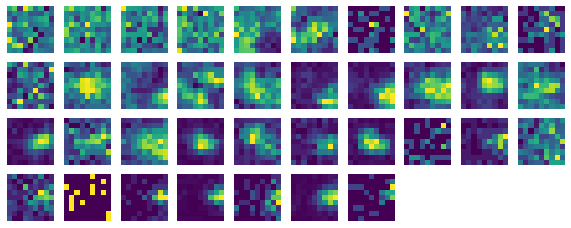

In [18]:
def plot_rf(unit_id, index):
    RF = rf_mapping.get_receptive_field(unit_id)
    _ = plt.subplot(6,10,index+1)
    _ = plt.imshow(RF)
    _ = plt.axis('off')
    
_ = plt.figure(figsize=(10,6))
_ = [plot_rf(RF, index) for index, RF in enumerate(am_units.index.values)]